# Modelado

In [3]:
import pandas as pd
import numpy as np

In [5]:
import re
import string
import nltk

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

##### Carga del dataset

In [13]:
df = pd.read_csv("../data/processed/reclamos_descripcionesv2.csv", low_memory=False)

In [15]:
df.isnull().sum()

ID_PERIODO                    0
DE_TIPO_ADMINISTRADO          0
CO_ADMIN_DECLA                0
CO_UGIPRESS                   0
DE_TIPO_INSTITUCION           0
CO_ADMIN_SUCE                 0
DE_MEDIO_PRESENTACION         0
CO_UNICO_RECLAMO              0
DE_MEDIO_RECEPCION            0
FE_PRESEN_RECLA               0
DE_SERVICIO                   0
DE_COMPETENCIA                0
DE_CLASIF_1                   0
DE_CLASIF_2                   0
DE_CLASIF_3                   0
DE_ESTADO_RECLAMO             0
CO_RECLAMO_PRIMIG             0
DE_ETAPA_RECLAMO              0
DE_TIPO_ADMIN_DERIVA          0
CO_ADMIN_DERIVA               0
DE_RESULTADO                  0
DE_MOTIVO_CONCL_ANTIC         0
FE_RESULT_RECL            97422
DE_COMUN_RESULT               0
FE_NOTIFI_RESULT         104740
AÑO                           0
MES                           0
DESCRIPCION                   0
dtype: int64

In [17]:
# Reemplazar '-' en la columna DESCRIPCION con NaN
df['DESCRIPCION'] = df['DESCRIPCION'].replace('-', np.nan)

# Calcular el porcentaje de descripciones vacías
porcentaje_vacios = df['DESCRIPCION'].isna().mean() * 100
print(f"Porcentaje de descripciones vacías: {porcentaje_vacios:.2f}%")

Porcentaje de descripciones vacías: 21.64%


In [19]:
# Comparar distribución de clases entre registros con y sin descripción
con_descripcion = df[df['DESCRIPCION'].notna()]['DE_CLASIF_1'].value_counts(normalize=True)
sin_descripcion = df[df['DESCRIPCION'].isna()]['DE_CLASIF_1'].value_counts(normalize=True)

# Mostrar diferencias
print("Distribución en registros CON descripción:")
print(con_descripcion)
print("\nDistribución en registros SIN descripción:")
print(sin_descripcion)

# Verificar si hay categorías sobrerrepresentadas en los datos sin descripción
diff = sin_descripcion - con_descripcion
print("\nDiferencias (positivo = más común en registros sin descripción):")
print(diff.sort_values(ascending=False))

Distribución en registros CON descripción:
DE_CLASIF_1
Otros relativos a las IAFAS                                                         0.345969
-                                                                                   0.298951
Cobrar indebidamente                                                                0.083130
No permitir al usuario la libre elección de IPRESS de acuerdo a lo contratado       0.065985
Negar la acreditación de usuario asegurado.                                         0.050212
No brindar información sobre sus derechos en salud                                  0.046971
Negar  o demora en otorgar la cobertura en salud                                    0.042530
Demorar la gestión de la carta de garantía y/o reembolsos.                          0.024592
Negar o demorar en la atención en la IAFAS                                          0.015913
Negar atención para el trámite de registro o acreditación                           0.007415
No brindar aten

In [21]:
# Objetivo
y = df["DE_CLASIF_1"]

In [23]:
print(y.value_counts(normalize=True))

DE_CLASIF_1
-                                                                                   0.389015
Otros relativos a las IAFAS                                                         0.271091
Negar la acreditación de usuario asegurado.                                         0.065206
Cobrar indebidamente                                                                0.065138
Negar  o demora en otorgar la cobertura en salud                                    0.055971
No permitir al usuario la libre elección de IPRESS de acuerdo a lo contratado       0.051703
No brindar información sobre sus derechos en salud                                  0.036805
Demorar la gestión de la carta de garantía y/o reembolsos.                          0.032428
Negar o demorar en la atención en la IAFAS                                          0.012469
Negar atención para el trámite de registro o acreditación                           0.005810
No brindar atención con respeto de parte del personal de l

In [25]:
# Variables a eliminar
cols_to_drop = [
    "DE_CLASIF_2", "DE_CLASIF_3", "DE_ESTADO_RECLAMO", "CO_RECLAMO_PRIMIG", "DE_ETAPA_RECLAMO", "DE_TIPO_ADMIN_DERIVA",
    "CO_ADMIN_DERIVA", "DE_RESULTADO", "DE_MOTIVO_CONCL_ANTIC", "FE_RESULT_RECL",
    "DE_COMUN_RESULT", "FE_NOTIFI_RESULT", "DE_TIPO_ADMINISTRADO"
]

In [27]:
df = df.drop(columns=cols_to_drop)

In [7]:
# Extraer mes y año como numéricos si quieres
#df["AÑO"] = df["ID_PERIODO"].astype(str).str[:4].astype(int)
#df["MES"] = df["ID_PERIODO"].astype(str).str[4:6].astype(int)
#df = df.drop(columns=["ID_PERIODO", "FE_PRESEN_RECLA"])  # ya extraído

In [29]:
df['FE_PRESEN_RECLA'] = pd.to_datetime(df['FE_PRESEN_RECLA'], format='%Y%m%d', errors='coerce')
df['MES'] = df['FE_PRESEN_RECLA'].dt.month
df['DIA_SEMANA'] = df['FE_PRESEN_RECLA'].dt.dayofweek

In [8]:
# Definir texto + estructuradas
text_column = "DESCRIPCION"

In [35]:
!pip install sentence_transformers

In [37]:
from sentence_transformers import SentenceTransformer

In [39]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
df['DESCRIPCION_EMB'] = list(model.encode(df['DESCRIPCION'].astype(str)))

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.46k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [40]:
encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [ ]:
# Columns to encode
columns_to_encode = [
    'DE_TIPO_INSTITUCION',
    'DE_MEDIO_PRESENTACION',
    'DE_MEDIO_RECEPCION',
    'DE_SERVICIO',
    'DE_COMPETENCIA'
]

In [ ]:
# Fit and transform the selected columns
encoded_data = encoder.fit_transform(df[columns_to_encode])

In [ ]:
# Create DataFrame with encoded column names
encoded_df = pd.DataFrame(
    encoded_data,
    columns=encoder.get_feature_names_out(columns_to_encode)
)

In [ ]:
# Reset index to ensure proper concatenation
encoded_df.index = df.index

In [ ]:
# Drop original columns and concatenate the encoded ones
df = df.drop(columns=columns_to_encode)
df = pd.concat([df, encoded_df], axis=1)

In [ ]:
# Display the first few rows of the transformed DataFrame
df.head()

In [9]:
categorical_features = [
    "DE_TIPO_ADMINISTRADO", "DE_TIPO_INSTITUCION",
    "DE_MEDIO_PRESENTACION", "DE_MEDIO_RECEPCION",
    "DE_SERVICIO", "DE_COMPETENCIA", "DE_ETAPA_RECLAMO", "DE_TIPO_ADMIN_DERIVA"
]

In [10]:
numeric_features = ["AÑO", "MES"]

In [11]:
X = df.drop(columns=["DE_CLASIF_1"])

In [24]:
# Reemplazar valores nulos en la columna de texto con una cadena vacía
df['DESCRIPCION'] = df['DESCRIPCION'].fillna('')

In [25]:
# Procesadores individuales
text_preprocessor = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2)))
])

In [26]:
categorical_preprocessor = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [27]:
# Ensamblaje de todo
preprocessor = ColumnTransformer([
    ("text", text_preprocessor, text_column),
    ("cat", categorical_preprocessor, categorical_features),
    ("num", "passthrough", numeric_features)
])

In [28]:
# Modelo completo
model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", XGBClassifier(
    objective="multi:softprob",  # Devuelve probabilidades por clase
    num_class=18,                # Muy importante
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="mlogloss"
)
)
])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [34]:
from sklearn.preprocessing import LabelEncoder

# Reemplazar valores nulos en la columna de texto con una cadena vacía
df['DESCRIPCION'] = df['DESCRIPCION'].fillna('')

# Asegurarse de que X_train no tenga valores nulos en la columna de texto
X_train['DESCRIPCION'] = X_train['DESCRIPCION'].fillna('')

# Codificar las etiquetas de y, y_train y y_test
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ahora puedes entrenar el modelo sin problemas
model.fit(X_train, y_train_encoded)

c:\Users\harol\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:23:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(1,
                                                                                                2)))]),
                                                  'DESCRIPCION'),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['DE_TIPO_ADMINISTRADO',
                                                   'DE_TIPO_INSTITUCION',
                                                   'DE_MEDIO_PRESENTACION',
                                                   'DE_MEDIO_RECEPC...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None, num_class=18,
                               num_parallel_tree=None, ...))])

In [36]:
# Replace NaN values in the DESCRIPCION column with an empty string
X_test['DESCRIPCION'] = X_test['DESCRIPCION'].fillna('')

# Make predictions
y_pred = model.predict(X_test)

In [38]:
# Ensure y_test is encoded to match y_pred
y_test_encoded = label_encoder.transform(y_test)

# Print the classification report
print(classification_report(y_test_encoded, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12654
           1       1.00      1.00      1.00      2119
           2       0.72      0.66      0.69      1055
           3       0.75      0.68      0.71      1821
           4       1.00      1.00      1.00       189
           5       1.00      1.00      1.00        47
           6       0.77      0.85      0.81      2121
           7       1.00      1.00      1.00        61
           8       1.00      0.89      0.94         9
           9       1.00      1.00      1.00       114
          10       1.00      1.00      1.00       406
          11       1.00      1.00      1.00       124
          12       1.00      0.50      0.67         4
          13       1.00      1.00      1.00      1197
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00        98
          16       1.00      1.00      1.00      1682
          17       1.00    

In [43]:
from sklearn.metrics import classification_report, f1_score

In [44]:
print(classification_report(y_test_encoded, y_pred, digits=3))
print("F1 macro:", f1_score(y_test_encoded, y_pred, average='macro'))


              precision    recall  f1-score   support

           0      0.998     1.000     0.999     12654
           1      1.000     1.000     1.000      2119
           2      0.723     0.664     0.692      1055
           3      0.747     0.681     0.713      1821
           4      1.000     1.000     1.000       189
           5      1.000     1.000     1.000        47
           6      0.770     0.847     0.807      2121
           7      1.000     1.000     1.000        61
           8      1.000     0.889     0.941         9
           9      1.000     1.000     1.000       114
          10      1.000     1.000     1.000       406
          11      1.000     1.000     1.000       124
          12      1.000     0.500     0.667         4
          13      1.000     1.000     1.000      1197
          14      1.000     1.000     1.000         9
          15      1.000     1.000     1.000        98
          16      0.999     1.000     1.000      1682
          17      1.000    

In [ ]:
# Crear un ejemplo de entrada
example = pd.DataFrame({
    'DE_TIPO_ADMINISTRADO': ['IAFAS'],
    'DE_TIPO_INSTITUCION': ['IAFAS'],
    'DE_MEDIO_PRESENTACION': ['Virtual'],
    'DE_MEDIO_RECEPCION': ['Libro de Reclamaciones Virtual'],
    'DE_SERVICIO': ['Consulta Externa'],
    'DE_COMPETENCIA': ['Si'],
    'DE_ETAPA_RECLAMO': ['Evaluación e investigación'],
    'DE_TIPO_ADMIN_DERIVA': ['-'],
    'AÑO': [2023],
    'MES': [5],
    'DESCRIPCION': ['El servicio de atención médica fue deficiente y tardaron en atenderme.']
})

# Realizar la predicción
example['DESCRIPCION'] = example['DESCRIPCION'].fillna('')  # Asegurarse de que no haya valores nulos
example_encoded = preprocessor.transform(example)  # Preprocesar el ejemplo
example_prediction = model.predict(example_encoded)  # Realizar la predicción

# Decodificar la predicción
predicted_label = label_encoder.inverse_transform(example_prediction)
print(f"Predicción: {predicted_label[0]}")

ValueError: X has 5044 features, but ColumnTransformer is expecting 14 features as input.

### PREPARACIÓN DE LOS DATOS

In [19]:
df.columns

Index(['ID_PERIODO', 'DE_TIPO_ADMINISTRADO', 'CO_ADMIN_DECLA', 'CO_UGIPRESS',
       'DE_TIPO_INSTITUCION', 'CO_ADMIN_SUCE', 'DE_MEDIO_PRESENTACION',
       'CO_UNICO_RECLAMO', 'DE_MEDIO_RECEPCION', 'FE_PRESEN_RECLA',
       'DE_SERVICIO', 'DE_COMPETENCIA', 'DE_CLASIF_1', 'DE_CLASIF_2',
       'DE_CLASIF_3', 'DE_ESTADO_RECLAMO', 'CO_RECLAMO_PRIMIG',
       'DE_ETAPA_RECLAMO', 'DE_TIPO_ADMIN_DERIVA', 'CO_ADMIN_DERIVA',
       'DE_RESULTADO', 'DE_MOTIVO_CONCL_ANTIC', 'FE_RESULT_RECL',
       'DE_COMUN_RESULT', 'FE_NOTIFI_RESULT', 'AÑO', 'MES', 'DESCRIPCION'],
      dtype='object')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162639 entries, 0 to 162638
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   ID_PERIODO             162639 non-null  int64 
 1   DE_TIPO_ADMINISTRADO   162639 non-null  object
 2   CO_ADMIN_DECLA         162639 non-null  int64 
 3   CO_UGIPRESS            162639 non-null  int64 
 4   DE_TIPO_INSTITUCION    162639 non-null  object
 5   CO_ADMIN_SUCE          162639 non-null  int64 
 6   DE_MEDIO_PRESENTACION  162639 non-null  object
 7   CO_UNICO_RECLAMO       162639 non-null  object
 8   DE_MEDIO_RECEPCION     162639 non-null  object
 9   FE_PRESEN_RECLA        162639 non-null  object
 10  DE_SERVICIO            162639 non-null  object
 11  DE_COMPETENCIA         162639 non-null  object
 12  DE_CLASIF_1            162639 non-null  object
 13  DE_CLASIF_2            162639 non-null  object
 14  DE_CLASIF_3            162639 non-null  object
 15  

In [9]:
# Eliminar filas con valores nulos en 'FE_NOTIFI_RESULT' y 'DESCRIPCION'
# df = df.dropna(subset=['FE_NOTIFI_RESULT', 'DESCRIPCION'])

In [18]:
print(df['DESCRIPCION'].isnull().sum())
print(df['FE_NOTIFI_RESULT'].isnull().sum())

63269
104740


In [ ]:
#df['FE_NOTIFI_RESULT'] = df['FE_NOTIFI_RESULT'].fillna('No notificado')
#df['DESCRIPCION'] = df['DESCRIPCION'].fillna('No disponible')

In [12]:
### Eliminación de variables no necesarias

In [22]:
columns_delete = [
    'ID_PERIODO',
    'CO_ADMIN_DECLA',
    'CO_UGIPRESS',
    'CO_ADMIN_SUCE',
    'DE_CLASIF_2',
    'DE_CLASIF_3',
    'CO_UNICO_RECLAMO',
    'CO_RECLAMO_PRIMIG',
    'DE_MOTIVO_CONCL_ANTIC',
    'CO_ADMIN_DERIVA',
    'DE_MOTIVO_CONCL_ANTIC'
]

In [23]:
df = df.drop(columns=columns_delete)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162639 entries, 0 to 162638
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   DE_TIPO_ADMINISTRADO   162639 non-null  object
 1   DE_TIPO_INSTITUCION    162639 non-null  object
 2   DE_MEDIO_PRESENTACION  162639 non-null  object
 3   DE_MEDIO_RECEPCION     162639 non-null  object
 4   FE_PRESEN_RECLA        162639 non-null  object
 5   DE_SERVICIO            162639 non-null  object
 6   DE_COMPETENCIA         162639 non-null  object
 7   DE_CLASIF_1            162639 non-null  object
 8   DE_ESTADO_RECLAMO      162639 non-null  object
 9   DE_ETAPA_RECLAMO       162639 non-null  object
 10  DE_TIPO_ADMIN_DERIVA   162639 non-null  object
 11  DE_RESULTADO           162639 non-null  object
 12  FE_RESULT_RECL         65217 non-null   object
 13  DE_COMUN_RESULT        162639 non-null  object
 14  FE_NOTIFI_RESULT       57899 non-null   object
 15  

### Datos categoricos 

In [25]:
print(df.dtypes)

DE_TIPO_ADMINISTRADO     object
DE_TIPO_INSTITUCION      object
DE_MEDIO_PRESENTACION    object
DE_MEDIO_RECEPCION       object
FE_PRESEN_RECLA          object
DE_SERVICIO              object
DE_COMPETENCIA           object
DE_CLASIF_1              object
DE_ESTADO_RECLAMO        object
DE_ETAPA_RECLAMO         object
DE_TIPO_ADMIN_DERIVA     object
DE_RESULTADO             object
FE_RESULT_RECL           object
DE_COMUN_RESULT          object
FE_NOTIFI_RESULT         object
AÑO                       int64
MES                       int64
DESCRIPCION              object
dtype: object


In [26]:
df['DE_COMPETENCIA'].dtype

dtype('O')

In [27]:
#pd.get_dummies(df['DE_MEDIO_PRESENTACION'])

### Categorias para codificarlas

In [28]:
# 1. Identify categorical columns 'DE_CLASIF_1'
categorical_columns = [
    'DE_TIPO_ADMINISTRADO', 'DE_TIPO_INSTITUCION', 'DE_MEDIO_PRESENTACION',
    'DE_MEDIO_RECEPCION', 'DE_SERVICIO', 'DE_COMPETENCIA',
    'DE_ESTADO_RECLAMO',
    'DE_ETAPA_RECLAMO', 'DE_TIPO_ADMIN_DERIVA', 'DE_RESULTADO',
    'DE_COMUN_RESULT'
]

In [29]:
# Preservar DE_CLASIF_1 original antes de one-hot encoding
y = df['DE_CLASIF_1'].copy()

In [32]:
# 2. Apply one-hot encoding using pandas get_dummies
df_encoded = pd.get_dummies(
    df,
    columns=categorical_columns,
    prefix=categorical_columns,
    prefix_sep='_',
    drop_first=True  # Drop first category to avoid multicollinearity
)

In [30]:
# Aplicar one-hot encoding a las demás variables categóricas
df_encoded = pd.get_dummies(
    df.drop(columns=['DE_CLASIF_1']),  # Excluir DE_CLASIF_1 del encoding
    columns=categorical_columns,
    prefix=categorical_columns,
    prefix_sep='_',
    drop_first=True
)

In [ ]:
# 3. Handle datetime columns separately
df_encoded['FE_PRESEN_RECLA'] = pd.to_datetime(df_encoded['FE_PRESEN_RECLA'])
df_encoded['FE_RESULT_RECL'] = pd.to_datetime(df_encoded['FE_RESULT_RECL'])
df_encoded['FE_NOTIFI_RESULT'] = pd.to_datetime(df_encoded['FE_NOTIFI_RESULT'])


ValueError: time data """ doesn't match format "%Y%m%d", at position 592. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [36]:
df_encoded['FE_NOTIFI_RESULT'] = pd.to_datetime(df_encoded['FE_NOTIFI_RESULT'], errors='coerce', format='%Y%m%d')

In [37]:
# Extract useful features from dates
for date_col in ['FE_PRESEN_RECLA', 'FE_RESULT_RECL', 'FE_NOTIFI_RESULT']:
    df_encoded[f'{date_col}_year'] = df_encoded[date_col].dt.year
    df_encoded[f'{date_col}_month'] = df_encoded[date_col].dt.month
    df_encoded[f'{date_col}_day'] = df_encoded[date_col].dt.day
    df_encoded = df_encoded.drop(columns=[date_col])

KeyError: 'FE_PRESEN_RECLA'

In [35]:
# 4. Print shape before and after encoding
print(f"Shape before encoding: {df.shape}")
print(f"Shape after encoding: {df_encoded.shape}")

Shape before encoding: (162639, 20)
Shape after encoding: (162639, 81)


In [36]:
# 5. Verify some of the new columns
print("\nSample of new encoded columns:")
print(df_encoded.columns[:10])


Sample of new encoded columns:
Index(['AÑO', 'MES', 'DURACION_RECLAMO', 'CATEGORIA_DURACION', 'DESCRIPCION',
       'DE_TIPO_INSTITUCION_IPRESS', 'DE_TIPO_INSTITUCION_UGIPRESS',
       'DE_MEDIO_PRESENTACION_Teléfonic', 'DE_MEDIO_PRESENTACION_Teléfonico',
       'DE_MEDIO_PRESENTACION_Virtual'],
      dtype='object')


In [ ]:
# 6. Save encoded DataFrame if needed
#df_encoded.to_csv('../data/processed/reclamos_encoded.csv', index=False)

KeyboardInterrupt: 

In [40]:
# Check number of unique categories in original vs encoded data
for col in categorical_columns:
    n_categories = len(df[col].unique())
    n_encoded = sum(1 for c in df_encoded.columns if c.startswith(f"{col}_"))
    print(f"{col}: {n_categories} categories -> {n_encoded} encoded columns")

DE_TIPO_ADMINISTRADO: 1 categories -> 0 encoded columns
DE_TIPO_INSTITUCION: 3 categories -> 2 encoded columns
DE_MEDIO_PRESENTACION: 4 categories -> 3 encoded columns
DE_MEDIO_RECEPCION: 7 categories -> 6 encoded columns
DE_SERVICIO: 15 categories -> 14 encoded columns
DE_COMPETENCIA: 3 categories -> 2 encoded columns
DE_CLASIF_1: 18 categories -> 17 encoded columns
DE_ESTADO_RECLAMO: 6 categories -> 5 encoded columns
DE_ETAPA_RECLAMO: 5 categories -> 4 encoded columns
DE_TIPO_ADMIN_DERIVA: 4 categories -> 3 encoded columns
DE_RESULTADO: 7 categories -> 6 encoded columns
DE_COMUN_RESULT: 6 categories -> 5 encoded columns


### Preprocesamiento de datos de texto (DESCRIPCION)

In [41]:
def clean_text(text):
    """
    Clean text by:
    1. Converting to lowercase
    2. Removing special characters and punctuation
    3. Removing stopwords
    4. Removing extra whitespace
    """
    if not isinstance(text, str):
        return ""
        
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('spanish'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [42]:
# Apply cleaning to DESCRIPCION column
df['DESCRIPCION_clean'] = df['DESCRIPCION'].apply(clean_text)

In [43]:
# Show sample results
print("Muestra de textos originales vs. limpios:")
for original, limpio in zip(df['DESCRIPCION'].head(), df['DESCRIPCION_clean'].head()):
    print("\nOriginal:", original)
    print("Limpio:", limpio)

Muestra de textos originales vs. limpios:

Original: Mi solicitud para recibir servicio de salud médico fue retrasada sin una justificación clara.
Limpio: solicitud recibir servicio salud médico retrasada justificación clara

Original: me cobró por una cirugía de emergencia que, como asegurado, debería estar cubierta.
Limpio: cobró cirugía emergencia asegurado debería cubierta

Original: Recibí un servicio deficiente de parte de la IAFAS.
Limpio: recibí servicio deficiente parte iafas

Original: El policlínico de mi zona no cuenta con traumatólogo, pese a ser una especialidad básica.
Limpio: policlínico zona cuenta traumatólogo pese ser especialidad básica

Original: Recibí un servicio deficiente de parte de la IAFAS.
Limpio: recibí servicio deficiente parte iafas


In [44]:
# Print basic statistics
print(f"\nNúmero de descripciones vacías: {df['DESCRIPCION_clean'].isna().sum()}")
print(f"Longitud promedio (palabras): {df['DESCRIPCION_clean'].str.split().str.len().mean():.2f}")


Número de descripciones vacías: 0
Longitud promedio (palabras): 3.86


### Construcción de la variable de urgencia (PRIORIDAD)

In [45]:
df['DE_SERVICIO'].unique()

array(['-', 'Farmacia',
       'Oficinas o áreas administrativas de IAFAS o IPRESS o UGIPRESS',
       'Servicios Médicos de Apoyo', 'Consulta Externa',
       'Hospitalización', 'Atención a domicilio, urgencia o emergencia',
       'Atención a domicilio, consulta ambulatoria', 'Emergencia',
       'Centro Quirúrgico', 'UCI o UCIN', 'Infraestructura',
       'Referencia y Contrareferencia', 'Centro Obstétrico',
       'Oficinas o áreas administrativas de IAFAS o IPRESS o UGIPRES'],
      dtype=object)

In [46]:
def asignar_prioridad(row):
    """
    Asigna prioridad basada en el servicio y duración del reclamo
    Alta: Servicios críticos o reclamos que duran más de 30 días
    Media: Servicios de atención directa
    Baja: Servicios administrativos y otros
    """
    servicios_alta = [
        'UCI o UCIN',
        'Emergencia',
        'Centro Quirúrgico',
        'Centro Obstétrico'
    ]
    
    servicios_media = [
        'Hospitalización',
        'Atención a domicilio, urgencia o emergencia',
        'Consulta Externa',
        'Referencia y Contrareferencia',
        'Atención a domicilio, consulta ambulatoria'
    ]
    
    if row['DURACION_RECLAMO'] > 30:
        return 'Alta'
    elif row['DE_SERVICIO'] in servicios_alta:
        return 'Alta'
    elif row['DE_SERVICIO'] in servicios_media:
        return 'Media'
    else:
        return 'Baja'

In [47]:
# Aplicar la función y crear nueva columna
df['PRIORIDAD'] = df.apply(asignar_prioridad, axis=1)

In [48]:
# Verificar la distribución de prioridades
print("Distribución de prioridades:")
print(df['PRIORIDAD'].value_counts())

Distribución de prioridades:
PRIORIDAD
Baja     139402
Alta      19183
Media      4054
Name: count, dtype: int64


In [49]:
# Mostrar ejemplos de cada prioridad
print("\nEjemplos de reclamos por prioridad:")
for prioridad in ['Alta', 'Media', 'Baja']:
    print(f"\nPrioridad {prioridad}:")
    muestra = df[df['PRIORIDAD'] == prioridad][['DE_SERVICIO', 'DURACION_RECLAMO', 'PRIORIDAD']].head(3)
    print(muestra.to_string())


Ejemplos de reclamos por prioridad:

Prioridad Alta:
   DE_SERVICIO  DURACION_RECLAMO PRIORIDAD
1            -                45      Alta
9            -                45      Alta
86           -                31      Alta

Prioridad Media:
                                      DE_SERVICIO  DURACION_RECLAMO PRIORIDAD
1613                             Consulta Externa                 0     Media
1614                             Consulta Externa                 0     Media
1622  Atención a domicilio, urgencia o emergencia                 0     Media

Prioridad Baja:
  DE_SERVICIO  DURACION_RECLAMO PRIORIDAD
0           -                24      Baja
2           -                14      Baja
3           -                19      Baja


In [ ]:
####

In [ ]:
#### Vectorizar (NLP) la columna descripcion 

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
# Vectorizar las descripciones con TF-IDF
spanish_stopwords = stopwords.words('spanish')
tfidf = TfidfVectorizer(stop_words=spanish_stopwords, max_features=5000)
X_text = tfidf.fit_transform(df['DESCRIPCION_clean'])  # Usamos la columna limpia

In [52]:
# Convertir a un DataFrame para concatenar más fácilmente
X_text_df = pd.DataFrame(X_text.toarray(), columns=tfidf.get_feature_names_out())

In [53]:
# Mostrar las dimensiones del DataFrame resultante
print(f"Dimensiones de la matriz TF-IDF: {X_text_df.shape}")

Dimensiones de la matriz TF-IDF: (162639, 2472)


In [54]:
# Mostrar las primeras filas y columnas
print("\nPrimeras 5 filas y 10 columnas:")
print(X_text_df.iloc[:5, :10])


Primeras 5 filas y 10 columnas:
   aarón   ab  abad  abascal  abel  abella  abellán  abigaíl  abilio  abraham
0    0.0  0.0   0.0      0.0   0.0     0.0      0.0      0.0     0.0      0.0
1    0.0  0.0   0.0      0.0   0.0     0.0      0.0      0.0     0.0      0.0
2    0.0  0.0   0.0      0.0   0.0     0.0      0.0      0.0     0.0      0.0
3    0.0  0.0   0.0      0.0   0.0     0.0      0.0      0.0     0.0      0.0
4    0.0  0.0   0.0      0.0   0.0     0.0      0.0      0.0     0.0      0.0


In [55]:
# Mostrar las palabras más relevantes (suma de los valores TF-IDF por columna)
feature_importance = X_text_df.sum().sort_values(ascending=False)
print("\nPalabras más relevantes según TF-IDF:")
print(feature_importance.head(20))


Palabras más relevantes según TF-IDF:
iafas             7636.780959
servicio          6262.311892
atención          5405.216310
policlínico       3385.964489
essalud           3228.561815
recibí            2843.023130
administración    2611.646128
inconvenientes    2611.646128
sido              2596.347695
parte             2451.806393
médica            2403.752091
tiempo            2394.101532
acceder           2332.875303
deficiente        2286.092990
brindan           2267.689662
calidad           2267.689662
establecidos      2254.133591
hospital          2253.071591
tiempos           2241.679272
cumplen           2241.679272
dtype: float64


In [ ]:
### Combinamos los datos estructurados y el texto

In [56]:
# Verificar que los índices coincidan (deberían ser los mismos, pero asegurémonos)
print(f"Índices de df_encoded: {len(df_encoded.index)}")
print(f"Índices de X_text_df: {len(X_text_df.index)}")

Índices de df_encoded: 162639
Índices de X_text_df: 162639


In [57]:
# Eliminar las columnas de texto del dataframe codificado antes de la concatenación
columns_to_drop = ['DESCRIPCION', 'DESCRIPCION_clean', 'texto_limpio'] 
df_encoded_no_text = df_encoded.drop(columns=[col for col in columns_to_drop if col in df_encoded.columns])

In [58]:
# Combinar datos estructurados con características de texto
X_combined = pd.concat([df_encoded_no_text, X_text_df], axis=1)

In [59]:
# Verificar las dimensiones del DataFrame combinado
print(f"Dimensiones de df_encoded sin texto: {df_encoded_no_text.shape}")
print(f"Dimensiones de X_text_df: {X_text_df.shape}")
print(f"Dimensiones de X_combined: {X_combined.shape}")

Dimensiones de df_encoded sin texto: (162639, 80)
Dimensiones de X_text_df: (162639, 2472)
Dimensiones de X_combined: (162639, 2552)


In [ ]:
# Guardar el DataFrame combinado si es necesario
#X_combined.to_csv('../data/processed/reclamos_combined_features.csv', index=False)

In [ ]:
###

In [60]:
# Opción 1: Verificar columnas categóricas en X_combined
categorical_cols = X_combined.select_dtypes(include=['object']).columns
print(f"Columnas categóricas no codificadas: {categorical_cols}")

Columnas categóricas no codificadas: Index(['CATEGORIA_DURACION'], dtype='object')


In [61]:
# Si hay columnas categóricas, codificarlas
if len(categorical_cols) > 0:
    # Usar one-hot encoding para las columnas encontradas
    X_combined = pd.get_dummies(X_combined, columns=categorical_cols, drop_first=True)
    print(f"Forma después de codificar columnas adicionales: {X_combined.shape}")

Forma después de codificar columnas adicionales: (162639, 2555)


In [ ]:
###

In [62]:
# Identificar columnas relacionadas con la variable objetivo (DE_CLASIF_1)
clasif_columns = [col for col in X_combined.columns if 'DE_CLASIF_1_' in col]
print(f"Removiendo {len(clasif_columns)} columnas relacionadas con DE_CLASIF_1: {clasif_columns[:5]}...")

Removiendo 17 columnas relacionadas con DE_CLASIF_1: ['DE_CLASIF_1_Cobrar indebidamente', 'DE_CLASIF_1_Demorar la gestión de la carta de garantía y/o reembolsos.', 'DE_CLASIF_1_Negar atención para el trámite de registro o acreditación', 'DE_CLASIF_1_Negar el otorgamiento de prestaciones económicas o sociales', 'DE_CLASIF_1_Negar la acreditación de usuario asegurado.']...


In [63]:
# Eliminar estas columnas de X_combined
X_combined_clean = X_combined.drop(columns=clasif_columns)
print(f"Forma de X_combined después de eliminar columnas de fuga: {X_combined_clean.shape}")

Forma de X_combined después de eliminar columnas de fuga: (162639, 2538)


In [ ]:
##

In [64]:
# Entrenar un modelo de Random Forest con características combinadas
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Dividir el conjunto de datos combinado en entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X_combined, df['DE_CLASIF_1'], test_size=0.2, random_state=42)

In [65]:
# Dividir el conjunto de datos LIMPIO en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_combined_clean,  # Usar el dataset limpio que ya has creado 
    df['DE_CLASIF_1'], 
    test_size=0.2, 
    random_state=42
)

In [66]:
# Inicializar y entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [67]:
# Realizar predicciones
y_pred = model.predict(X_test)

In [68]:
# Evaluar el rendimiento
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'\nReporte de clasificación:\n{classification_report(y_test, y_pred)}')

Accuracy: 0.9914227742252828


c:\Users\harol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Reporte de clasificación:
                                                                                  precision    recall  f1-score   support

                                                                               -       1.00      1.00      1.00     12640
                                                            Cobrar indebidamente       1.00      1.00      1.00      2107
                      Demorar la gestión de la carta de garantía y/o reembolsos.       0.85      0.94      0.90      1030
                       Negar atención para el trámite de registro o acreditación       1.00      0.99      1.00       196
                     Negar el otorgamiento de prestaciones económicas o sociales       1.00      0.92      0.96        49
                                     Negar la acreditación de usuario asegurado.       0.96      0.94      0.95      2173
                                                 Negar la afiliación del usuario       1.00      0.62      0.76       

c:\Users\harol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\harol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
# Corregir para usar X_combined_clean en lugar de X_combined
feature_importances_clean = pd.DataFrame({
    'feature': X_combined_clean.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 características más importantes (datos limpios):")
print(feature_importances_clean.head(20))


Top 20 características más importantes (datos limpios):
                                                feature  importance
28                                    DE_COMPETENCIA_No    0.072991
29                                    DE_COMPETENCIA_Si    0.058248
1219                                              iafas    0.040804
2230                                           servicio    0.030453
49                   DE_COMUN_RESULT_Correo electrónico    0.021566
294                                            atención    0.019682
48                                   DE_COMUN_RESULT_-     0.018784
38            DE_ETAPA_RECLAMO_Resultado y Notificación    0.016832
9     DE_MEDIO_RECEPCION_Libro de Reclamaciones Virtual    0.015031
10                DE_MEDIO_RECEPCION_Llamada teléfonica    0.014598
1886                                        policlínico    0.014451
37          DE_ETAPA_RECLAMO_Evaluación e investigación    0.014345
923                                             essalud    

In [72]:
# Identificar y eliminar columnas adicionales con fuga potencial
additional_leakage = [col for col in X_combined_clean.columns 
                     if 'DE_RESULTADO_' in col or 'DE_ESTADO_RECLAMO_' in col]

print(f"Eliminando {len(additional_leakage)} columnas adicionales con potencial fuga")
X_combined_cleaner = X_combined_clean.drop(columns=additional_leakage)

# Reentrenar con datos más limpios
X_train_cleaner, X_test_cleaner, y_train, y_test = train_test_split(
    X_combined_cleaner, df['DE_CLASIF_1'], test_size=0.2, random_state=42
)

model_cleaner = RandomForestClassifier(n_estimators=100, random_state=42)
model_cleaner.fit(X_train_cleaner, y_train)
y_pred_cleaner = model_cleaner.predict(X_test_cleaner)

print(f'Nueva accuracy: {accuracy_score(y_test, y_pred_cleaner)}')

Eliminando 11 columnas adicionales con potencial fuga
Nueva accuracy: 0.9908386620757501


In [73]:
from sklearn.model_selection import cross_val_score

# Validación cruzada con 5-fold
cv_scores = cross_val_score(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_combined_cleaner, df['DE_CLASIF_1'], 
    cv=5
)
print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV Accuracy: 0.9735 ± 0.0131


In [74]:
# Eliminar TODAS las variables posteriores a la clasificación
post_classification_cols = [col for col in X_combined_cleaner.columns 
                           if any(substring in col for substring in [
                               'DE_RESULTADO_', 
                               'DE_ESTADO_RECLAMO_',
                               'DE_ETAPA_RECLAMO_',
                               'DE_COMUN_RESULT_',
                               'FE_RESULT_RECL_',
                               'FE_NOTIFI_RESULT_'
                           ])]

print(f"Eliminando {len(post_classification_cols)} columnas con información posterior a la clasificación")
X_combined_truly_clean = X_combined_cleaner.drop(columns=post_classification_cols)

# Validación cruzada con el conjunto realmente limpio
cv_scores_clean = cross_val_score(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_combined_truly_clean, df['DE_CLASIF_1'], 
    cv=5
)
print(f"CV Accuracy realmente limpia: {cv_scores_clean.mean():.4f} ± {cv_scores_clean.std():.4f}")

Eliminando 15 columnas con información posterior a la clasificación
CV Accuracy realmente limpia: 0.9793 ± 0.0106


In [78]:
# Verificar si estás incluyendo alguna variable que tenga información directa del resultado
print(feature_importances.head(20))

NameError: name 'feature_importances' is not defined

In [ ]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 1000x1000 with 0 Axes>

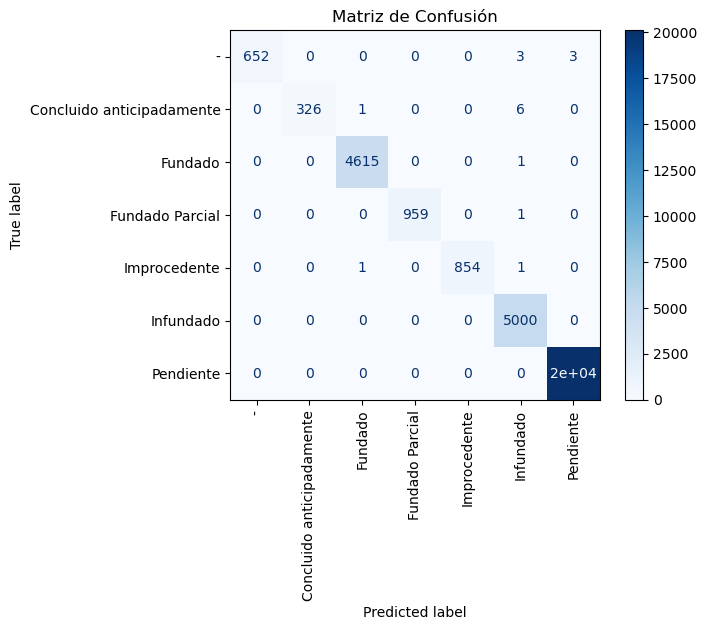

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plt.figure(figsize=(10, 10))
disp.plot(cmap='Blues')
plt.xticks(rotation=90)
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Ver distribución de clases en el conjunto de prueba
print("Distribución de clases en el conjunto de prueba:")
print(y_test.value_counts(normalize=True))


Distribución de clases en el conjunto de prueba:
DE_RESULTADO
Pendiente                    0.618083
Infundado                    0.153714
Fundado                      0.141909
Fundado Parcial              0.029513
Improcedente                 0.026316
-                            0.020229
Concluido anticipadamente    0.010237
Name: proportion, dtype: float64


In [ ]:
# Ver características más importantes
feature_importances = pd.DataFrame({
    'feature': X_combined.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 20 características más importantes:")
print(feature_importances.head(20))


Top 20 características más importantes:
                                                feature  importance
63                               DE_RESULTADO_Infundado    0.116272
60                                 DE_RESULTADO_Fundado    0.110432
53    DE_ETAPA_RECLAMO_Archivo y Custodia del Expedi...    0.069610
78                                 FE_NOTIFI_RESULT_day    0.067789
2                                      DURACION_RECLAMO    0.060794
64                               DE_RESULTADO_Pendiente    0.048359
76                                FE_NOTIFI_RESULT_year    0.047134
48                          DE_ESTADO_RECLAMO_Concluido    0.046104
77                               FE_NOTIFI_RESULT_month    0.042632
61                         DE_RESULTADO_Fundado Parcial    0.038074
66                   DE_COMUN_RESULT_Correo electrónico    0.037771
49                         DE_ESTADO_RECLAMO_En trámite    0.033640
62                            DE_RESULTADO_Improcedente    0.029845
29     

In [76]:
# Identifica todas las variables que podrían contener información posterior a la clasificación
# Observa variables de duración o aquellas derivadas de la fecha de presentación vs resultado
temporal_leakage_cols = [col for col in X_combined_truly_clean.columns 
                         if 'DURACION_RECLAMO' in col]

print(f"Columnas con potencial fuga temporal: {temporal_leakage_cols}")

# También inspecciona columnas calculadas en base a fechas posteriores a la clasificación
date_derived_cols = [col for col in X_combined_truly_clean.columns 
                    if any(substring in col for substring in ['_year', '_month', '_day'])]
print(f"Columnas derivadas de fechas: {date_derived_cols}")

# Eliminar todas las columnas identificadas como problemáticas
X_combined_final_clean = X_combined_truly_clean.drop(columns=temporal_leakage_cols)

# Validación cruzada con conjunto completamente limpio
from sklearn.model_selection import cross_val_score
cv_scores_final = cross_val_score(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_combined_final_clean, df['DE_CLASIF_1'], 
    cv=5
)
print(f"CV Accuracy final: {cv_scores_final.mean():.4f} ± {cv_scores_final.std():.4f}")

Columnas con potencial fuga temporal: ['DURACION_RECLAMO']
Columnas derivadas de fechas: ['FE_PRESEN_RECLA_year', 'FE_PRESEN_RECLA_month', 'FE_PRESEN_RECLA_day']
CV Accuracy final: 0.9793 ± 0.0112


In [77]:
# Examina exactamente qué columnas quedan en tu conjunto de datos final
print("Columnas restantes:")
for col in X_combined_final_clean.columns[:30]:  # Mostrar las primeras 30
    print(f"- {col}")
print(f"...y {len(X_combined_final_clean.columns) - 30} columnas más")

# Verifica si hay otras variables calculadas que podrían contener información posterior
remaining_suspicious = [col for col in X_combined_final_clean.columns 
                       if any(term in col.lower() for term in ['result', 'duracion', 'tiempo'])]
print(f"Posibles columnas problemáticas restantes: {remaining_suspicious}")

Columnas restantes:
- AÑO
- MES
- DE_TIPO_INSTITUCION_IPRESS
- DE_TIPO_INSTITUCION_UGIPRESS
- DE_MEDIO_PRESENTACION_Teléfonic
- DE_MEDIO_PRESENTACION_Teléfonico
- DE_MEDIO_PRESENTACION_Virtual
- DE_MEDIO_RECEPCION_Libro de Reclamaciones Físico
- DE_MEDIO_RECEPCION_Libro de Reclamaciones Virtual
- DE_MEDIO_RECEPCION_Llamada teléfonica
- DE_MEDIO_RECEPCION_Reclamo coparticipado con otra administrada
- DE_MEDIO_RECEPCION_Reclamo presencial
- DE_MEDIO_RECEPCION_Reclamo trasladado de otra administrada
- DE_SERVICIO_Atención a domicilio, consulta ambulatoria
- DE_SERVICIO_Atención a domicilio, urgencia o emergencia
- DE_SERVICIO_Centro Obstétrico
- DE_SERVICIO_Centro Quirúrgico
- DE_SERVICIO_Consulta Externa
- DE_SERVICIO_Emergencia
- DE_SERVICIO_Farmacia
- DE_SERVICIO_Hospitalización
- DE_SERVICIO_Infraestructura
- DE_SERVICIO_Oficinas o áreas administrativas de IAFAS o IPRESS o UGIPRES
- DE_SERVICIO_Oficinas o áreas administrativas de IAFAS o IPRESS o UGIPRESS
- DE_SERVICIO_Referencia y Co

In [79]:
# Eliminar las palabras 'tiempo' y 'tiempos' de las características TF-IDF
text_time_cols = ['tiempo', 'tiempos']
# Eliminar las categorías de duración
duracion_cols = [col for col in X_combined_final_clean.columns if 'CATEGORIA_DURACION_' in col]

# Unir todas las columnas a eliminar
final_cols_to_drop = text_time_cols + duracion_cols

# Eliminar estas columnas del conjunto de datos final
X_combined_truly_final = X_combined_final_clean.drop(columns=final_cols_to_drop)

print(f"Forma después de eliminar las últimas columnas problemáticas: {X_combined_truly_final.shape}")

# Verificar que ya no queden columnas sospechosas
remaining_suspicious = [col for col in X_combined_truly_final.columns 
                       if any(term in col.lower() for term in ['result', 'duracion', 'tiempo'])]
print(f"Columnas posiblemente problemáticas restantes: {remaining_suspicious}")

Forma después de eliminar las últimas columnas problemáticas: (162639, 2505)
Columnas posiblemente problemáticas restantes: []


In [81]:
# Validación cruzada con el conjunto finalmente limpio
cv_scores_truly_final = cross_val_score(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_combined_truly_final, df['DE_CLASIF_1'], 
    cv=5
)
print(f"CV Accuracy final real: {cv_scores_truly_final.mean():.4f} ± {cv_scores_truly_final.std():.4f}")

CV Accuracy final real: 0.9802 ± 0.0104


In [82]:
print("Comparación de rendimiento:")
print(f"Modelo con posible fuga de información: {cv_scores_final.mean():.4f} ± {cv_scores_final.std():.4f}")
print(f"Modelo sin fuga de información: {cv_scores_truly_final.mean():.4f} ± {cv_scores_truly_final.std():.4f}")

Comparación de rendimiento:
Modelo con posible fuga de información: 0.9793 ± 0.0112
Modelo sin fuga de información: 0.9802 ± 0.0104
